# Measuring density

Measuring density is a typical exercise in urban analytics. `momepy` allows to measure different types (see [API/Intensity](https://docs.momepy.org/en/latest/api.html#intensity)); this notebook will outline the main principles.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer.

In [2]:
import osmnx as ox

point = (40.731603, -73.977857)
dist = 1000
gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]

buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/Users/martin/Git/geopandas/geopandas/geoseries.py:190: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/Users/martin/Git/momepy/momepy/elements.py:386: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [217, 405, 833, 835, 1994, 3053, 3056, 3070, 3136, 3147, 3157, 3163]
  warnings.warn(


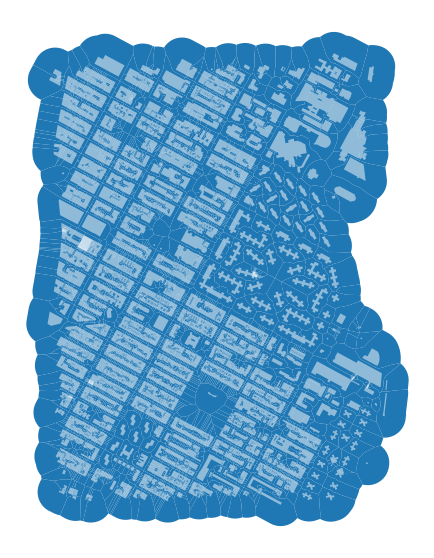

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

We have some edge effect here as we are using the buffer as a limit for tessellation in the middle of the urban fabric, but for these examples, we can work with it anyway. Keep in mind that values on the edge of this area will be skewed.

## Covered Area Ratio

Covered area ratio, in our case measured on tessellation cells, requires `GeoDataFrame` containing spatial unit (cell, plot), and `GeoDataFrame` containing covering objects (buildings). On top of that, it currently requires passed areas for both gdfs and unique ID which links together spatial units and objects on them. We can either calculate areas before:

In [4]:
tessellation['area'] = momepy.Area(tessellation).series
buildings['area'] = momepy.Area(buildings).series
tess_car = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID')
tessellation['CAR'] = tess_car.series

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Or we can pass `momepy.Area().series` directly:

In [5]:
tess_car = momepy.AreaRatio(tessellation, buildings,
                            momepy.Area(tessellation).series,
                            momepy.Area(buildings).series, 'uID')
tessellation['CAR'] = tess_car.series

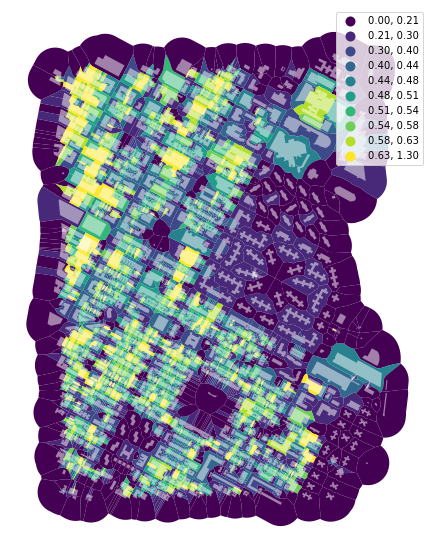

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='CAR', legend=True, scheme='quantiles', k=10, cmap='viridis')
buildings.plot(ax=ax, color='white', alpha=0.5)
ax.set_axis_off()
plt.show()

## Floor Area Ratio

Because we know building heights for our `buildings` gdf, we can also calculate FAR. This part of New York has height data, only stored as strings, so we have to convert them to `floats` (or `int`) and fill `NaN` values with zero.

FAR requires floor areas for building gdf instead of covered area.

In [7]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0

buildings['height'] = buildings['height'].fillna(0).apply(clean_heights)

buildings['floor_area'] = momepy.FloorArea(buildings, 'height').series

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [8]:
tessellation['FAR'] = momepy.AreaRatio(tessellation, buildings,
                                       'area', 'floor_area', 'uID').series

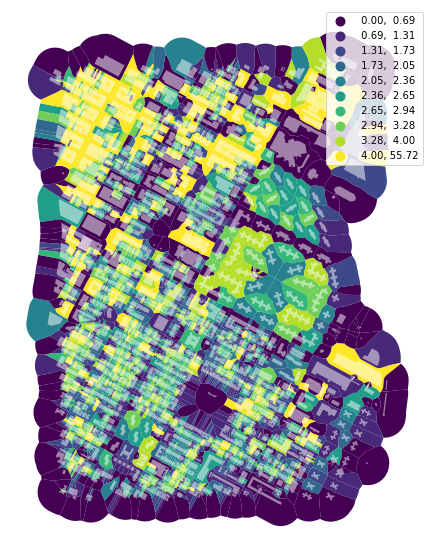

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='FAR', legend=True, scheme='quantiles', k=10, cmap='viridis')
buildings.plot(ax=ax, color='white', alpha=0.5)
ax.set_axis_off()
plt.show()

Location-based density is described in [examples using spatial weights](../weights/examples.ipynb).